# Importing Dependencies

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

import os

### Loading data

In [5]:
source_path = os.path.join('data', 'main_data')

for i in os.listdir(source_path):
    if i == 'sample_submission.csv':
        path_data = os.path.join(source_path, i)
        sample_submission = pd.read_csv(path_data)
    elif i == 'train.csv':
        path_data = os.path.join(source_path, i)
        train_data = pd.read_csv(path_data)
    elif i == 'games.csv':
        path_data = os.path.join(source_path, i)
        games_data = pd.read_csv(path_data, parse_dates = ['created_at'])
    elif i == 'turns.csv':
        path_data = os.path.join(source_path, i)
        turns_data = pd.read_csv(path_data)
    else:
        path_data = os.path.join(source_path, i)
        test_data = pd.read_csv(path_data)

Project Goal: The goal of this project is to predict the ratings of players based on their Scrabble gameplay.

The games are between the bots on Woogles.io: BetterBot (beginner), STEEBot (intermediate), and HastyBot (advanced) and regular registered users. 

We will train our model on gameplay data from one set of human opponents to make predictions about a different set of human opponents in the test set.

**Data Descriptions**

* games.csv - metadata about games (e.g., who went first, time controls)
* turns.csv - all turns from start to finish of each game
* train.csv - final scores and ratings for each player in each game; ratings for each player are as of BEFORE the game was played
* test.csv - final scores and ratings for each player in each game; ratings for each player are as of BEFORE the game was played
* sample_submission.csv - a sample submission file in the correct format

# EDA

## Exploring the `games.csv` file

We will begin our exploratory analysis with the games.csv file.

In [6]:
# first 5 entries
games_data.head()

,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


In [7]:
games_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72773 entries, 0 to 72772
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   game_id                72773 non-null  int64         
 1   first                  72773 non-null  object        
 2   time_control_name      72773 non-null  object        
 3   game_end_reason        72773 non-null  object        
 4   winner                 72773 non-null  int64         
 5   created_at             72773 non-null  datetime64[ns]
 6   lexicon                72773 non-null  object        
 7   initial_time_seconds   72773 non-null  int64         
 8   increment_seconds      72773 non-null  int64         
 9   rating_mode            72773 non-null  object        
 10  max_overtime_minutes   72773 non-null  int64         
 11  game_duration_seconds  72773 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory

There are a total of 72773 entries in our dataset.

Before we proceed further, let us have a quick look at what each of these attributes mean:

* game_id: unique id for the game
* first: player who went first
* time_control_name: Name of time control used ("regular", "rapid", or "blitz")
* game_end_reason: How the game ended
* winner: who won the game
* created_at: the time when then the game was created
* lexicon: English lexicon used in the game ("CSW19", "NWL20", "CSW21")
* initial_time_seconds: the time limit each player has in the game
* increment_seconds: time increment each player gets each time they play a turn
* rating_mode: whether the game counts towards player ratings or not ("RATED", "CASUAL")
* max_overtime_minutes: how far past the initial time limit players can go before they timeout
* game_duration_seconds: how long the game lasted


### Are there any missing entries?


In [8]:
games_data.isna().sum()

game_id                  0
first                    0
time_control_name        0
game_end_reason          0
winner                   0
created_at               0
lexicon                  0
initial_time_seconds     0
increment_seconds        0
rating_mode              0
max_overtime_minutes     0
game_duration_seconds    0
dtype: int64

There are no mssing entries.

### Visualizing `game_duration_seconds`

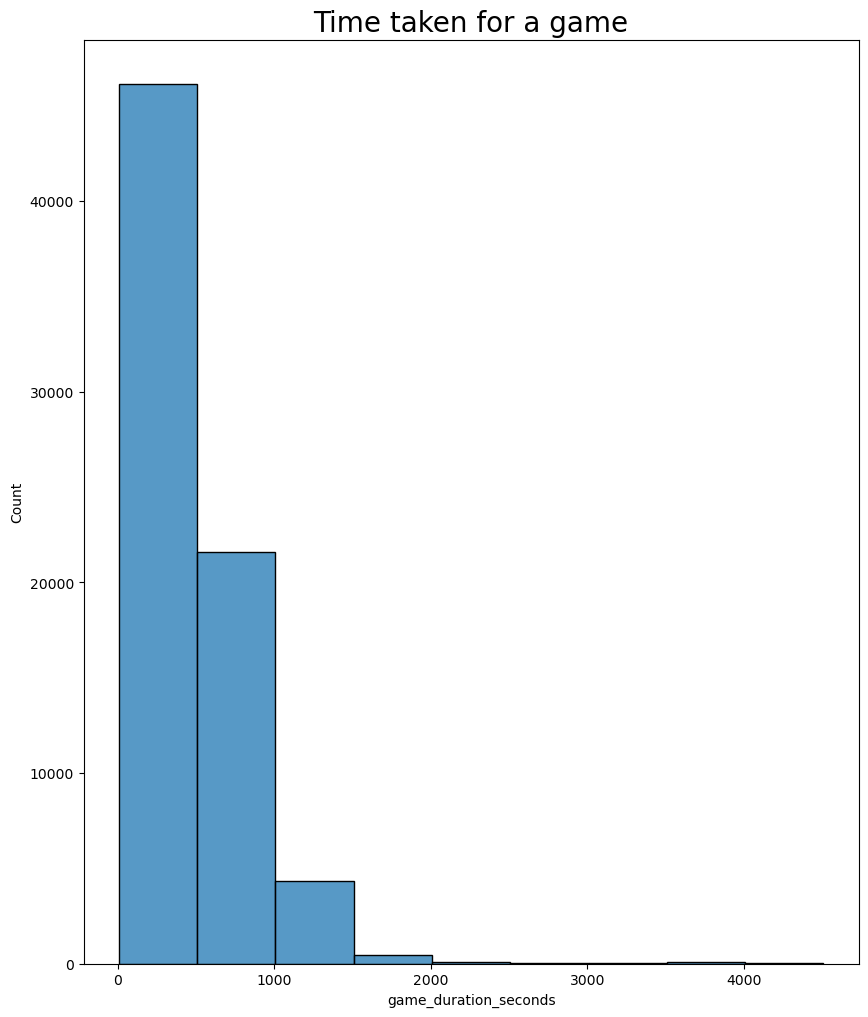

In [9]:
fig, ax = plt.subplots(figsize=(10,12))
ax = sns.histplot(data=games_data, x="game_duration_seconds",binwidth=500)
ax.set_title('Time taken for a game', fontsize=20)
plt.show()

We can see that the game_duration is skewed to the right. Most games take less than 500 seconds.

### Inspecting `created_at` feature:

In [10]:
# Separating the date and time
game_date = games_data.created_at.dt.date
game_time = games_data.created_at.dt.time

In [11]:
# Unique dates
x , y = np.unique(game_date, return_counts=True)

len(x)

59

There are 59 unique days.

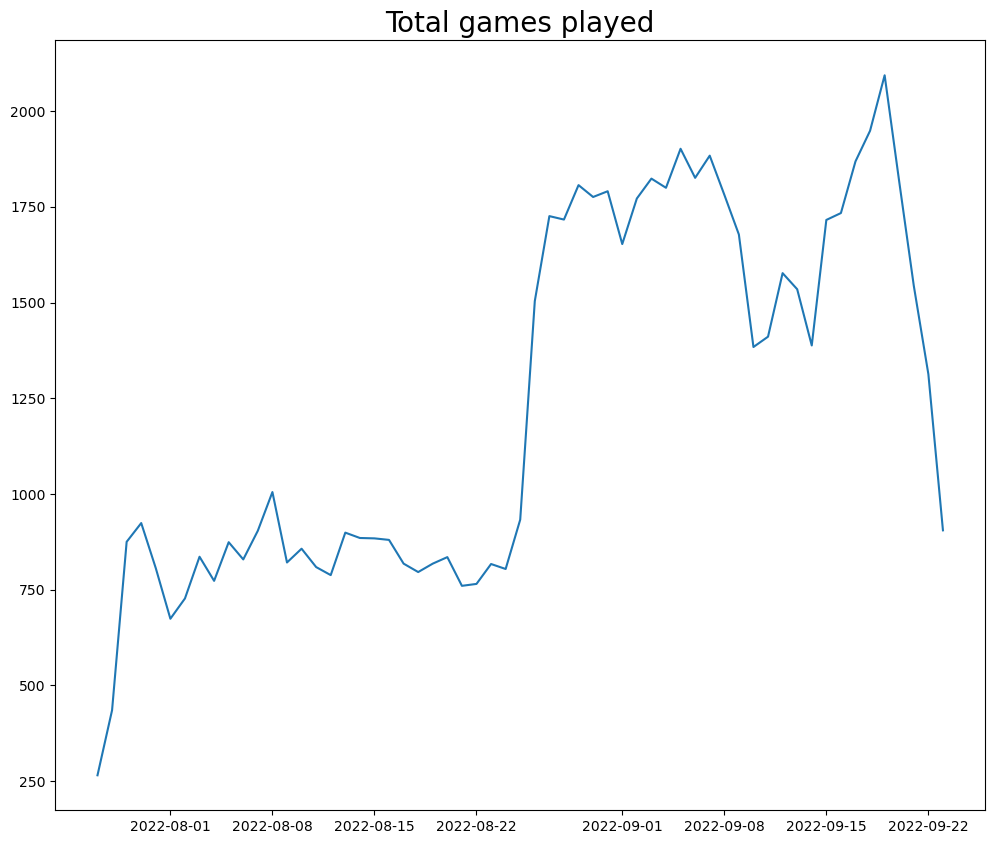

In [12]:
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.lineplot(x=x, y=y)
ax.set_title('Total games played', fontsize=20)
plt.show()

Most games seem to have been played during September 2022.

In [13]:
temp_game_df = games_data.copy()

temp_game_df['game_created_time'] = games_data.created_at.dt.time
temp_game_df['game_created_date'] = games_data.created_at.dt.date
temp_game_df['game_created_day'] = games_data.created_at.dt.strftime('%A')
temp_game_df.drop(columns = 'created_at', inplace = True)

temp_game_df.head()

,game_id,first,time_control_name,game_end_reason,winner,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds,game_created_time,game_created_date,game_created_day
0,1,BetterBot,regular,STANDARD,1,NWL20,1200,0,CASUAL,1,674.844274,03:38:49,2022-08-26,Friday
1,2,Super,regular,STANDARD,1,CSW21,3600,0,RATED,1,364.214418,19:19:59,2022-08-10,Wednesday
2,3,BetterBot,regular,STANDARD,1,CSW21,900,0,RATED,5,492.268262,08:04:27,2022-09-04,Sunday
3,4,BetterBot,regular,RESIGNED,0,CSW21,3600,0,CASUAL,1,350.861141,02:36:19,2022-09-12,Monday
4,5,STEEBot,regular,STANDARD,0,NWL20,1200,0,CASUAL,1,642.688722,04:31:36,2022-09-06,Tuesday


### Inpecting `game_end_reason`:

In [14]:
k, v = np.unique(temp_game_df.game_end_reason, return_counts=True)

for key, val in zip(k,v):
  print(f'{key} has {val} values')

CONSECUTIVE_ZEROES has 238 values
RESIGNED has 2346 values
STANDARD has 67987 values
TIME has 2202 values


We can do the same for the `lexicon` and `rating_mode` features:

In [15]:
k, v = np.unique(temp_game_df.lexicon, return_counts=True)

for key, val in zip(k,v):
  print(f'{key} has {val} values')

CSW21 has 44594 values
ECWL has 6925 values
NSWL20 has 4 values
NWL20 has 21250 values


In [16]:
k, v = np.unique(temp_game_df.rating_mode, return_counts=True)

for key, val in zip(k,v):
  print(f'{key} has {val} values')

CASUAL has 18697 values
RATED has 54076 values


## Exploring the `turns.csv` file

The turns.csv contains full data for every turn for each game.

In [17]:
turns_data.head()

,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


In [18]:
turns_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2005498 entries, 0 to 2005497
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   game_id      int64 
 1   turn_number  int64 
 2   nickname     object
 3   rack         object
 4   location     object
 5   move         object
 6   points       int64 
 7   score        int64 
 8   turn_type    object
dtypes: int64(4), object(5)
memory usage: 137.7+ MB


In [19]:
turns_data.shape

(2005498, 9)

There are a total of 2005498 entries and 9 columns.

Before proceeding any further, let us have a quick look at what each of these 9 columns mean:

* game_id: unique id for the game
* turn_number: the turn number in the game
* nickname: the player's username on woogles.io
* rack: the player's current rack
* location: where the player places their turn on the board (NA for games in the test set or if the player didn't make a play, e.g., if they exchanged)
* move: the tiles the player laid (NA for games in the test set; "--" if the turn_type was "Pass"; "(challenge)" if the turn_type was "Challenge"; "-" plus tiles exchanged if the turn_type was "Exchange"; at the end of the game, remaining tiles in a player's rack are in parentheses)
* points: points the player earned (or lost) in their turn
* score: the player's total score at the time of the turn
* turn_type: the type of turn played ("Play", "Exchange", "Pass", "Six-Zero Rule" (i.e., a game that ends when players pass 3 turns in a row each), "Challenge")


In [20]:
turns_data.isna().sum()

game_id             0
turn_number         0
nickname            0
rack            69390
location       132239
move              454
points              0
score               0
turn_type         395
dtype: int64

There seem to be a lot of missing values. However, before we can try imputation, notice that some of the features are missing for test data entirely. So, even if we train on these features, since our training set doesnot have these features, we cannot do much with it.

## Exploring training and test set

In [21]:
train_data.head(10)

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473
5,4,BetterBot,478,1936
6,5,stevy,325,1500
7,5,STEEBot,427,1844
8,6,HivinD,378,2029
9,6,STEEBot,427,2143


In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100820 entries, 0 to 100819
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   game_id   100820 non-null  int64 
 1   nickname  100820 non-null  object
 2   score     100820 non-null  int64 
 3   rating    100820 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.1+ MB


There are no missing values

### Checking how many of each bots we have:

In [23]:
name, games_played = np.unique(train_data.nickname, return_counts= True)

In [24]:
bot_names = ['BetterBot', 'STEEBot', 'HastyBot']

In [25]:
bot_count = defaultdict()
for n, g in zip(name, games_played):
  for i in bot_names:
    if n == i:
      bot_count[n] = g

bot_count

defaultdict(None, {'BetterBot': 16602, 'HastyBot': 17346, 'STEEBot': 16462})

In [26]:
test_data.head()

,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


In [27]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44726 entries, 0 to 44725
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   game_id   44726 non-null  int64  
 1   nickname  44726 non-null  object 
 2   score     44726 non-null  int64  
 3   rating    22363 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


In [28]:
test_data.isna().sum()

game_id         0
nickname        0
score           0
rating      22363
dtype: int64

the missing 22363 ratings are what we need to predict. 

## Checking the `sample_submission.csv` to see what we need to output:

In [29]:
sample_submission.head()

,game_id,rating
0,2,1790.322674
1,7,1790.322674
2,11,1790.322674
3,14,1790.322674
4,27,1790.322674


We already know the rating for the bots. Moreover, the games are only played between bots and human players. Each game has 2 rows: one for the bot and the other for the human player. 

# Baseline Regression Model

In [30]:
bot_data = train_data.loc[train_data['nickname'].isin(bot_names)].copy()
bot_data.head()

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
3,3,BetterBot,318,2071
5,4,BetterBot,478,1936
7,5,STEEBot,427,1844
9,6,STEEBot,427,2143


In [31]:
bot_data.rename(columns={'nickname':'bot_nickname', 'score': 'bot_score', 'rating': 'bot_rating'}, inplace= True )

In [32]:
human_data = train_data.loc[~train_data['nickname'].isin(bot_names)].copy()
human_data.head()

,game_id,nickname,score,rating
1,1,stevy,429,1500
2,3,davidavid,440,1811
4,4,Inandoutworker,119,1473
6,5,stevy,325,1500
8,6,HivinD,378,2029


In [33]:
# Join the two dataframe
training_data = human_data.join(bot_data.set_index('game_id'), on='game_id')

# Move the rating column to the end
column_to_move = training_data.pop("rating")

training_data.insert(6, "rating", column_to_move)

In [34]:
training_data.head()

,game_id,nickname,score,bot_nickname,bot_score,bot_rating,rating
1,1,stevy,429,BetterBot,335,1637,1500
2,3,davidavid,440,BetterBot,318,2071,1811
4,4,Inandoutworker,119,BetterBot,478,1936,1473
6,5,stevy,325,STEEBot,427,1844,1500
8,6,HivinD,378,STEEBot,427,2143,2029


This will be our initial training dataset.

### Data Preprocessing

* Dropping the nickname and game_id columns since it is unique and will not help with the model training:

In [35]:
training_data.drop(columns=["nickname", 'game_id'], inplace=True)

* Converting the bot_nickname feature:

In [36]:
training_data = pd.get_dummies(training_data, drop_first=True)

* seperating the rating feture and Standardizing the numeric features:

In [37]:
train_y = training_data["rating"]

training_data.drop(columns="rating", inplace=True)

In [38]:
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split

In [39]:
std = StandardScaler()

scaled_training = training_data.copy()
col_names = ['score', 'bot_score','bot_rating']
features = scaled_training[col_names]
scaler = StandardScaler().fit_transform(features.values)

scaled_training[col_names] = scaler

In [40]:
scaled_training.head()

,score,bot_score,bot_rating,bot_nickname_HastyBot,bot_nickname_STEEBot
1,0.727804,-1.235350,-1.615941,0,0
2,0.879031,-1.476747,0.549536,0,0
4,-3.534045,0.795230,-0.124057,0,0
6,-0.701978,0.071037,-0.583098,0,1
8,0.026661,0.071037,0.908786,0,1


We will use Random Forest as our basline: 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(scaled_training, train_y, test_size=0.3, random_state=123)

In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
rf = RandomForestRegressor(random_state=123, n_estimators=500, criterion='squared_error')

rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=123)

In [44]:
rf.score(X_test, y_test)

0.5921070364105625

In [45]:
bot_test_data = test_data.loc[test_data['nickname'].isin(bot_names)].copy()
bot_test_data.head()

,game_id,nickname,score,rating
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
4,11,STEEBot,334,1829.0
6,14,STEEBot,403,2136.0
9,27,HastyBot,453,2258.0


In [46]:
bot_test_data.rename(columns={'nickname':'bot_nickname', 'score': 'bot_score', 'rating': 'bot_rating'}, inplace= True )

In [47]:
human_test_data = test_data.loc[~test_data['nickname'].isin(bot_names)].copy()
human_test_data.head()

,game_id,nickname,score,rating
0,2,Super,488,NaN
3,7,Priya1,379,NaN
5,11,TileRunner,462,NaN
7,14,Anfield223,359,NaN
8,27,friesbasil,456,NaN


In [48]:
# Join the two dataframe
testing_data = human_test_data.join(bot_test_data.set_index('game_id'), on='game_id')

# Move the rating column to the end
column_to_move = testing_data.pop("rating")

testing_data.insert(6, "rating", column_to_move)

In [49]:
testing_data.drop(columns=["nickname", 'game_id'], inplace=True)

In [50]:
scaled_testing = testing_data.copy()
col_names = ['score', 'bot_score','bot_rating']
features = scaled_testing[col_names]
scaler = StandardScaler().fit_transform(features.values)

scaled_testing[col_names] = scaler

In [51]:
scaled_testing = pd.get_dummies(scaled_testing, drop_first=True)

scaled_testing.drop(columns="rating", inplace=True)

In [52]:
rating = rf.predict(scaled_testing)

In [53]:
sample_submission['rating'] = rating

In [54]:
sample_submission.head()

,game_id,rating
0,2,2045.036
1,7,1944.730
2,11,1748.290
3,14,2016.828
4,27,2019.142


# Submit predictions using the Kaggle Api

In [55]:
prediction_path = os.path.join('predictions', 'baseline.csv')

In [56]:
sample_submission.to_csv(prediction_path, index = False)